In [39]:
import pandas as pd
import numpy as np
import datetime

In [40]:
table_15min = pd.read_csv("./code_generated_csv/table_15min.csv",index_col = 0)

In [41]:
table_15min.head()

,Time,Open,High,Low,Close,Volume,NumberOfTrades,BidVolume,AskVolume
0,2020-01-01 17:00:00,28553,28578,28538,28574,1591,1307,650,941
1,2020-01-01 17:15:00,28575,28590,28571,28587,526,453,243,283
2,2020-01-01 17:30:00,28587,28587,28569,28571,434,346,265,169
3,2020-01-01 17:45:00,28571,28577,28566,28569,187,177,94,93
4,2020-01-01 18:00:00,28568,28572,28565,28568,299,282,118,181


In [83]:
table_15min.Time[0] > table_15min.Time[1]

False

## Heikin-Ashi

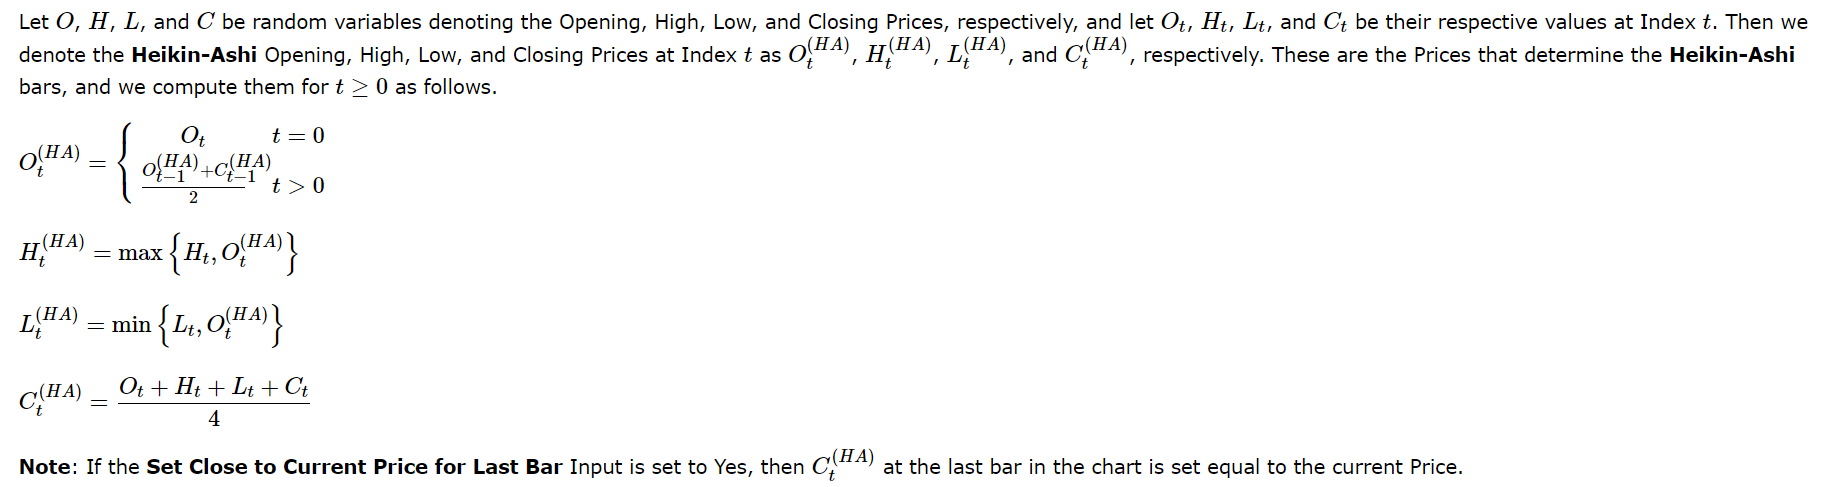

In [42]:
df_to_array = np.array(table_15min.loc[:,['Open','High','Low','Close']])
HA_Close_no = np.mean(df_to_array, axis=1)#Set Close to Current Price for Last Bar为no的情况
HA_Close_yes = np.append(HA_Close_no[:-1],table_15min.Close.iloc[-1])#sc中用的是yes
# HA_Close_no

In [43]:
HA_Open = []
HA_Open_sub = table_15min.Open.iloc[0]
for i in range(len(HA_Close_no)):#这边也可以换成HA_Close_yes
    HA_Open.append(HA_Open_sub)
    HA_Open_sub = np.mean([HA_Open_sub ,HA_Close_no[i]])

In [44]:
HA_High = np.max(np.array([table_15min.High, HA_Open]),axis=0)
HA_Low = np.min(np.array([table_15min.Low, HA_Open]),axis=0)

In [45]:
OHLC = [(Time,Open,High,Low,Close) for Time,Open,High,Low,Close in zip(table_15min.Time,HA_Open,HA_High,HA_Low,HA_Close_no)]#这里用的是no的数据

In [46]:
from pandas.core.frame import DataFrame

In [47]:
df_OHLC = DataFrame(OHLC,columns = ["Time","Open","High","Low","Close"])

In [59]:
df_OHLC

,Time,Open,High,Low,Close
0,2020-01-01 17:00:00,28553.000000,28578.000000,28538.0000,28560.75
1,2020-01-01 17:15:00,28556.875000,28590.000000,28556.8750,28580.75
2,2020-01-01 17:30:00,28568.812500,28587.000000,28568.8125,28578.50
3,2020-01-01 17:45:00,28573.656250,28577.000000,28566.0000,28570.75
4,2020-01-01 18:00:00,28572.203125,28572.203125,28565.0000,28568.25
...,...,...,...,...,...
24214,2021-01-15 14:30:00,30804.707571,30804.707571,30726.0000,30760.75
24215,2021-01-15 14:45:00,30782.728785,30782.728785,30696.0000,30724.50
24216,2021-01-15 15:00:00,30753.614393,30753.614393,30646.0000,30687.50
24217,2021-01-15 15:30:00,30720.557196,30720.557196,30635.0000,30652.50


In [87]:
1 if (df_OHLC.Open - df_OHLC.Close)>0 

0        False
1        False
2        False
3         True
4         True
         ...  
24214     True
24215     True
24216     True
24217     True
24218     True
Length: 24219, dtype: bool

## Keltner Channel

In [10]:
'''
Input Data:X(需要对输入的数据OHLC Avg进行四舍五入)
Keltner Mov Avg Length:nK
True Range Avg Length:nTR
Top Band Multiplier:vT
Bottom Band Multiplier:vB
分为三条线：
Top Band
The band in the middle
Bottom Band
'''

'\nInput Data:X(需要对输入的数据OHLC Avg进行四舍五入)\nKeltner Mov Avg Length:nK\nTrue Range Avg Length:nTR\nTop Band Multiplier:vT\nBottom Band Multiplier:vB\n分为三条线：\nTop Band\nThe band in the middle\nBottom Band\n'

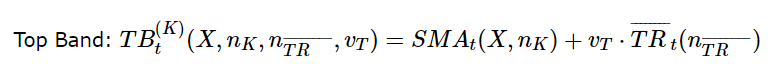

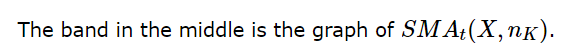

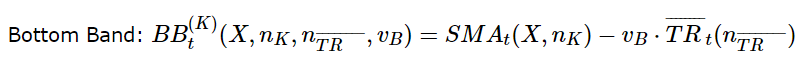

In [11]:
# import talib

In [48]:
def Keltner_Channel(X,df,nK,nTR,vT,vB):
    '''
    X的input可选Open,High,Low,Last,volume,#of trades,OHLC Avg,HLC Avg,HL Avg,Bid Volume,Ask Volume
    df为提供开高低收数据的dataframe
    '''
#     sma_X = talib.SMA(X,nK)
    sma_X = pd.Series(X).rolling(nK).mean()
#     ATR = talib.ATR(df.High,df.Low,df.Close,timeperiod = nTR)
    #自己算TR
    TR = np.max([(df.High - df.Low),abs(df.High - df.Close.shift(1)),abs(df.Low - df.Close.shift(1))],axis = 0)
#     ATR = talib.SMA(TR,nTR)
    ATR = pd.Series(TR).rolling(nTR).mean()
    Top_Band = sma_X + vT * ATR
    Middle_Band = sma_X
    Bottom_Band = sma_X - vB * ATR   
    
    return {"Top_Band":Top_Band,"Middle_Band":Middle_Band,"Bottom_Band":Bottom_Band}

In [49]:
a = Keltner_Channel(np.round(HA_Close_no),table_15min,7,14,2,1.5)["Top_Band"]

In [50]:
b = Keltner_Channel(np.round(HA_Close_no),table_15min,7,14,2,1.5)["Middle_Band"]

In [51]:
c = Keltner_Channel(np.round(HA_Close_no),table_15min,7,14,2,1.5)["Bottom_Band"]

In [52]:
KC = [(Time,OHLC_Avg,Top_Band,Middle_Band,Bottom_Band) for Time,OHLC_Avg,Top_Band,Middle_Band,Bottom_Band in zip(table_15min.Time,HA_Close_no,a,b,c)]

In [53]:
df_KC = DataFrame(KC,columns = ["Time","OHLC_Avg","Top_Band","Middle_Band","Bottom_Band"])

In [54]:
df_KC = df_KC.dropna()

In [19]:
# df_KC.to_csv("df_KC.csv")

In [20]:
comparewith = pd.read_csv(r"C:\Users\Administrator\Desktop\pythonHistoricalTesting\data\SCData\YM_study_data.txt")

In [21]:
comparewith = comparewith.loc[:,['Date', ' Time',' OHLC Avg',' Top',' Keltner Average',' Bottom']]

In [22]:
# comparewith.to_csv("comparewith.csv")

## 用pyecharts绘制两个studies

In [5]:
bb_data = pd.read_csv(r"C:\Users\Administrator\Desktop\pythonHistoricalTesting\code_generated_csv\table_15min.csv",index_col = 0)
bb_data.head()

,Time,Open,High,Low,Close,Volume,NumberOfTrades,BidVolume,AskVolume
0,2020-01-01 17:00:00,28553,28578,28538,28574,1591,1307,650,941
1,2020-01-01 17:15:00,28575,28590,28571,28587,526,453,243,283
2,2020-01-01 17:30:00,28587,28587,28569,28571,434,346,265,169
3,2020-01-01 17:45:00,28571,28577,28566,28569,187,177,94,93
4,2020-01-01 18:00:00,28568,28572,28565,28568,299,282,118,181


In [5]:
#5min的ATR(用SMA)
def BBand(df,nTR,n):
    """
    nTR表示TR的平滑周期，n表示布林带的上下轨为TR标准差的n倍
    """
    BB_table = pd.DataFrame(columns = ["Time","bb_top","ATR","bb_bottom"])
    TR = np.max([(df.High - df.Low),abs(df.High - df.Close.shift(1)),abs(df.Low - df.Close.shift(1))],axis = 0)
    ATR = pd.Series(TR).rolling(nTR).mean()
    rolling_std = pd.Series(TR).rolling(nTR).std()
    bb_top = ATR + n * rolling_std
    bb_bottom = ATR - n * rolling_std
    BB_table["Time"] = df.Time
    BB_table["bb_top"] = bb_top
    BB_table["ATR"] = ATR
    BB_table["bb_bottom"] = bb_bottom
    return BB_table

In [7]:
bb = BBand(bb_data,20,1)

In [8]:
# bb.to_csv("./code_generated_csv/bb.csv")

In [6]:
import talib

In [67]:
#直接用high-low算TR，并且使用EMA算ATR
# from decimal import Decimal
# from decimal import getcontext
# getcontext().prec = 4#保留4位小数
def ATR_EMA_BBand(df,T):
    TR = df.High - df.Low
    ATR = talib.EMA(TR,timeperiod = T)
    rolling_TR_std = pd.Series(TR).rolling(T).std()
    ATR_bottom_line = ATR - rolling_TR_std
    ATR_top_line = ATR + rolling_TR_std
    return df.Time,TR,ATR_top_line

In [68]:
atr = ATR_EMA_BBand(bb_data,14)

In [84]:
atr[2]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
24214    66.066518
24215    67.641459
24216    74.169445
24217    72.347819
24218    70.868594
Length: 24219, dtype: float64

In [85]:
atr[2].shift(1)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
24214    60.954912
24215    66.066518
24216    67.641459
24217    74.169445
24218    72.347819
Length: 24219, dtype: float64

In [70]:
ddf = df_OHLC.copy()
ddf['TR'] = atr[1]
ddf['ATR_top_line'] = atr[2]
ddf

,Time,Open,High,Low,Close,TR,ATR_top_line
0,2020-01-01 17:00:00,28553.000000,28578.000000,28538.0000,28560.75,40,NaN
1,2020-01-01 17:15:00,28556.875000,28590.000000,28556.8750,28580.75,19,NaN
2,2020-01-01 17:30:00,28568.812500,28587.000000,28568.8125,28578.50,18,NaN
3,2020-01-01 17:45:00,28573.656250,28577.000000,28566.0000,28570.75,11,NaN
4,2020-01-01 18:00:00,28572.203125,28572.203125,28565.0000,28568.25,7,NaN
...,...,...,...,...,...,...,...
24214,2021-01-15 14:30:00,30804.707571,30804.707571,30726.0000,30760.75,72,66.066518
24215,2021-01-15 14:45:00,30782.728785,30782.728785,30696.0000,30724.50,61,67.641459
24216,2021-01-15 15:00:00,30753.614393,30753.614393,30646.0000,30687.50,82,74.169445
24217,2021-01-15 15:30:00,30720.557196,30720.557196,30635.0000,30652.50,44,72.347819


In [71]:
ddf['ATR_top_line'] = ddf.ATR_top_line.shift(1)
ddf

,Time,Open,High,Low,Close,TR,ATR_top_line
0,2020-01-01 17:00:00,28553.000000,28578.000000,28538.0000,28560.75,40,NaN
1,2020-01-01 17:15:00,28556.875000,28590.000000,28556.8750,28580.75,19,NaN
2,2020-01-01 17:30:00,28568.812500,28587.000000,28568.8125,28578.50,18,NaN
3,2020-01-01 17:45:00,28573.656250,28577.000000,28566.0000,28570.75,11,NaN
4,2020-01-01 18:00:00,28572.203125,28572.203125,28565.0000,28568.25,7,NaN
...,...,...,...,...,...,...,...
24214,2021-01-15 14:30:00,30804.707571,30804.707571,30726.0000,30760.75,72,60.954912
24215,2021-01-15 14:45:00,30782.728785,30782.728785,30696.0000,30724.50,61,66.066518
24216,2021-01-15 15:00:00,30753.614393,30753.614393,30646.0000,30687.50,82,67.641459
24217,2021-01-15 15:30:00,30720.557196,30720.557196,30635.0000,30652.50,44,74.169445


In [81]:
ddf['is_TR_mt_ATR_top_line'] = (ddf.TR - ddf.ATR_top_line) > 0
ddf

,Time,Open,High,Low,Close,TR,ATR_top_line,is_TR_mt_ATR_top_line
0,2020-01-01 17:00:00,28553.000000,28578.000000,28538.0000,28560.75,40,NaN,False
1,2020-01-01 17:15:00,28556.875000,28590.000000,28556.8750,28580.75,19,NaN,False
2,2020-01-01 17:30:00,28568.812500,28587.000000,28568.8125,28578.50,18,NaN,False
3,2020-01-01 17:45:00,28573.656250,28577.000000,28566.0000,28570.75,11,NaN,False
4,2020-01-01 18:00:00,28572.203125,28572.203125,28565.0000,28568.25,7,NaN,False
...,...,...,...,...,...,...,...,...
24214,2021-01-15 14:30:00,30804.707571,30804.707571,30726.0000,30760.75,72,60.954912,True
24215,2021-01-15 14:45:00,30782.728785,30782.728785,30696.0000,30724.50,61,66.066518,False
24216,2021-01-15 15:00:00,30753.614393,30753.614393,30646.0000,30687.50,82,67.641459,True
24217,2021-01-15 15:30:00,30720.557196,30720.557196,30635.0000,30652.50,44,74.169445,False
